In [1]:
import os

import altair
import geopandas
import ibis
import intake
import IPython.display
import numpy
import pandas

/home/ian/miniconda3/envs/civis2/lib/python3.8/site-packages/intake/source/discovery.py:133: FutureWarning: The drivers ['geopandasfile'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  warnings.warn(


In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

In [3]:
if not os.path.exists("cpas.sqlite") or True:
    import s3fs
    fs = s3fs.S3FileSystem()
    fs.download("s3://hcid-cdbg-project-ita-data/cpas.sqlite", "cpas.sqlite")

con = ibis.sqlite.connect("cpas.sqlite")
gpr = con.table("grnt_gpr").execute(limit=None)

In [4]:
idx, size = zip(*[(name, sum(gpr[name].notna())) for name in gpr.columns])
counts = pandas.Series(size, idx).sort_values(ascending=False)

In [5]:
for c in counts.iteritems():
    #print(c)
    pass

In [6]:
public_access_metrics = {
    "pub_new_accs_nbr": "Members of the public with new access",
    "pub_improv_accs_nbr": "Members of the public with improved access",
}
business_assist_metrics = {
    "busi_asst_new_nbr": "New businesses assisted",
    "busi_asst_exist_nbr": "Existing businesses assisted",
    "busi_asst_cmty_need_nbr": "Businesses assisted with community need",
    "busi_asst_rehab_nbr": "Businesses rehabilitated",
    "busi_asst_exist_expnd_nbr": "Businesses expanded",
    "busi_asst_exist_reloc_nbr": "Businesses relocated",
}

job_metrics = {
    "actl_job_retn_pt_hr": "Part-time or hourly jobs retained",
    "actl_job_crt_ptlm_hr": "Low-mod part-time jobs created",
    "actl_job_retn_ft_nbr": "Full-time jobs retained",
    "actl_job_retn_ptlm_hr": "Low-mod part-time or hourly jobs retained",
    "actl_job_retn_ftlm_nbr": "Low-mod full-time jobs retained",
    "actl_job_crt_ftlm_nbr": "Low-mod full-time jobs created",
    "actl_job_crt_ft_nbr": "Full-time jobs created",
    "actl_job_crt_pt_hr": "Part-time or hourly jobs created",
}

In [7]:
cols = {
    "grnt_gpr_id": "Grant GPR ID",
    "dept": "Department",
    "yr": "Year",
    "proj_nm": "Project Name",
    "proj_addr": "Address",
    "proj_desc": "Description",
    "fund_amt": "Funding",
    "accmplsh_narrtv": "Accomplishment Status",
}

def subset_data(gpr, metrics):
    # Subset the projects
    projects = (
        gpr
        [numpy.logical_or.reduce([gpr[c].notna() for c in metrics])]
        .filter(list(cols.keys())+list(metrics.keys()))
        .rename(columns={**cols, **metrics})
        .assign(
            Year=lambda x: pandas.to_datetime(x.Year.astype("str")),
            Department=lambda x: x.Department.str.upper(),
        ).replace({"Department": "EWD"}, "EWDD")
        .reset_index(drop=True)
    )
    projects = projects.assign(**{
            f"{m} per million $": projects[m]/projects["Funding"]*1e6 for m in metrics.values()
    })
    return projects

def plot_metrics(projects, metrics):
    # Create the base chart
    select = altair.selection_single()

    base = altair.Chart().mark_point().encode(
        x=altair.X("Funding:Q",  scale=altair.Scale(type="log", base=10)),
        color=altair.condition(select, 'Department:N', altair.ColorValue('gray')),
        tooltip=list(cols.values()),
    ).add_selection(select)

    # Repeat for the metrics
    ncols = 3
    nrows = int(numpy.ceil(len(metrics)/ncols))
    chart = altair.vconcat(data=projects[projects.Funding > 0])
    for i in range(nrows):
        row = altair.hconcat()
        for j in range(ncols):
            idx = i*nrows+j
            if idx > len(metrics)-1:
                continue
            encoding = list(metrics.values())[idx]
            row |= base.encode(y=altair.Y(encoding, type="quantitative"))
        chart &= row
    return chart


In [8]:
metrics = job_metrics
projects = subset_data(gpr, metrics)
plot_metrics(projects, metrics)

alt.VConcatChart(...)

In [9]:
# choose the top metric as a stand-in for showing high-performing outliers
metric = projects[metrics.values()].sum().sort_values(ascending=False).index[0] + " per million $"
ranked = projects[projects.Funding > 0].sort_values([metric, "Funding"], ascending=[False, True]).set_index("Grant GPR ID")
high_performing = ranked.dropna(subset=[metric]).head(100)
low_performing = ranked.dropna(subset=[metric]).tail(100).iloc[::-1]

In [10]:
def display_table(df):
    return df.assign(
        Funding=df.Funding/1.e6,
        Year=df.Year.dt.year,
    ).filter(
        [
            "Year",
            "Project Name",
            "Department",
            metric,
            "Funding",
            "Description",
            "Accomplishment Status"
        ]
    ).reset_index(drop=True).style.hide_index()

In [11]:
display(IPython.display.Markdown("# High-Performing Projects"))
display_table(high_performing)

# High-Performing Projects

Year,Project Name,Department,Part-time or hourly jobs created per million $,Funding,Description,Accomplishment Status
2011,Port Tech Incubator,EWDD,5600.000000,0.050000,"CDBG funds will be spent on operations costs including personnel, rent, utilities and tenant improvements for facility. An initial $1 million has been expended resulting in a balance of $50,000. The balance will be brought forward and expended as described.","(PY15): THE PORT TECH LA INCUBATOR CONTRACT TERM WILL BE EXTENDED FOR TIME UNTIL DECEMBER 2016 AND NO NEW FUNDS HAVE BEEN ADDED AND THE SCOPE OF WORK REMAINS THE SAME. THE JOB CREATION GOAL HAS BEEN MET AND THE GOAL FOR LOW-MOD JOBS HAS BEEN EXCEEDED. NO FUNDS WERE AWARDED TO PORT TECH LA IN THE 42ND YEAR CON PLAN. THE CITY OF LA AND PORT TECH LA ARE CURRENTLY WORKING TOGETHER ON A SUSTAINABILITY PLAN WHICH WILL RESULT IN THE RESTRUCTURING OF PORT TECH LA. ALTHOUGH PORT TECH LA WILL HAVE A PRESENCE IN THE HARBOR AREA OF THE CITY AND REMAIN A 501C3, IT'S ORGANIZATIONAL STRUCTURE AND ADMINISTRATION MAY CHANGE. PORT TECH HAS PROVIDED ASSISTANCE TO 13 COMPANIES WHO CREATED NEW JOBS IN THE CLEAN TECH INDUSTRY. THESE COMPANIES ARE NEWLY FORMED AND DO NOT HAVE DUNS NUMBERS."
2008,LABAP-RETAIL BUSINESS ASSISTANCE CENTERS-DOWNTOWN,CDD/EDD,4790.960452,0.221250,"PROVIDES BUSINESS TRAINING, WORKSHOPS, TECHNICAL ASSISTANCE,AND REFERRALS TO ATTTRACT, STABILIZE, AND GROW RETAIL BUSINESSES IN HISTORIC DOWNTOWN LOS ANGELES.",(PY08):
2018,LA BUSINESS SOURCE PROGRAM,EWDD,4246.648794,0.186500,"The Los Angeles Business Source Center system will be operated by nine community-based organizations (one for each service are) with expertise and experience in providing technical assistance to businesses. The training components target microenterprises, including prestartups and startups, and operating small business populations. Serves West Valley.",(PY18): DATA ENTERED AS OF 4/30/19. ALL ACCOMPLISHMENTS WILL BE LISTED ON THE FINAL PY 44 GPR REPORTING.
2016,LA BusinesSource Program,EWDD,4079.967360,0.083334,"The Los Angeles Business Source Center System will be operated by nine community-based organizations (one for each service areas) with expertise and experience in providing technical assistance to businesses. The training components target microenterprises, including prestartups and startups, and operating small business populations.",0
2016,LA BusinesSource Program,EWDD,3843.395717,0.031222,"The Los Angeles Business Source System will be operated by nine community-based organizations (one for each of nine service areas) with expertise and experience in providing technical assistance to businesses. The training components target microenterprises, including prestartups and startups, and operating small business populations.",0
2017,LA BUSINESS SOURCE PROGRAM,EWDD,3600.000000,0.200000,"ACTIVITY WILL SERVE THE HARBOR WATTS AREA AND WILL BE CARRIED OUT BY MCS, INC. CDBG FUNDS WILL BE USED TO PROVIDE BUSINESS SERVICES, INCLUDING: TECHNICAL ASSISTANCE, BUSINESS ASSESSMENT, BUSINESS & MARKETING PLAN DEVELOPMENT, ACCESS TO CAPITAL, LOAN PACKAGING, SITE FINDING ASSISTANCE, FINANCIAL MANAGEMENT, TECHNOLOGY TRAINING, E-COMMERCE, HUMAN RESOURCES AND NETWORKING. SERVICES WILL LEAD TO BUSINESS GROWTH AND JOB CREATIONRETENTION THAT WILL BE MADE AVAILABLE TO LOW-MOD INCOME PERSONS.",0
2018,LA BUSINESS SOURCE PROGRAM,EWDD,3495.978552,0.186500,"The Los Angeles Business Source Center system will be operated by nine community-based organizations (one for each service are) with expertise and experience in providing technical assistance to businesses. The training components target microenterprises, including prestartups and startups, and operating small business populations. Serves West Valley.",0
2016,LA BusinesSource Program,EWDD,3119.975040,0.083334,"The Los Angeles Business Source Center System will be operated by nine community-based organizations (One for each of nine service areas) with expertise and experience in providing technical assistan

In [12]:
display(IPython.display.Markdown("# Low-Performing Projects"))
display_table(low_performing)

# Low-Performing Projects

Year,Project Name,Department,Part-time or hourly jobs created per million $,Funding,Description,Accomplishment Status
2009,Section 108 Loan Dolby / Kodak Theater,EWDD,0.000000,28.823000,Capital improvements to the Dolby (formerly Kodak) Theater in Hollywood to accommodate the Cirque du Soleil performances.,(PY17): Project was completed in 2011 and loan was fully disbursed. However Cirque Dul Soleil performance was cancelled two years after loan was fully repaid. Accomplishment data is best effort on reporting national objective and job creation but project failed to meet 51% low / moderate income requirement.
2009,Section 108 Loan Dolby / Kodak Theater,EWDD,0.000000,28.823000,Capital improvements to the Dolby (formerly Kodak) Theater in Hollywood to accommodate the Cirque du Soleil performances.,(PY17): Project was completed in 2011 and loan was fully disbursed. However Cirque Dul Soleil performance was cancelled two years after loan was fully repaid. Accomplishment data is best effort on reporting national objective and job creation but project failed to meet 51% low / moderate income requirement.
2008,Section 108 Loan 959 Seward,EWDD,0.000000,25.000000,"pre construction / soft costs to support development of a 245,000 square foot office, campus-like development with landscaped courtyard and onsite amenities.",0
2008,Section 108 Loan 959 Seward,EWDD,0.000000,22.725000,"Section 108 loan for eligible pre constructionsoft costs to support development of a 245,000 square foot office, campus-like development with landscaped courtyard and onsite amenities.","(PY17): Construction was completed in 2015. Project is approximately 50% occupied. Developer is still in leasing effort. Project turned in first job report in 2018.. (PY18): THRU 4TH QTR PY 2018: CONSTRUCTION OF THE PROJECT HAS BEEN COMPLETED IN 2015. PROJECT IS NOT FULLY OCCUPIED, JOB REPORT HAS BEEN SUBMITTED EVERY YEAR. EDD WILL MONITOR UNTIL CONTRACTUAL GOAL IS MET."
2010,Section 108 Loan District Square Retail,EWDD,0.000000,22.675000,"Demolish existing structures and construct approximate 300,000 sq ft retail complex.",0
2008,Section 108 Loan 5860 W Jefferson Building (RAD Beverly),EWDD,0.000000,18.200000,"Acquisition of real property, financing and pre-development costs associated with development of an office building",(PY17): Cancel this project. The developer passed away and 108 loan was fully repaid by trustee in January 2015. Project was not completed and no jobs were reported.
2008,Section 108 Loan 5860 W Jefferson Building (RAD Beverly),EWDD,0.000000,18.200000,"Acquisition of real property, financing and pre-development costs associated with development of an office building",(PY17): Cancel this project. The developer passed away and 108 loan was fully repaid by trustee in January 2015. Project was not completed and no jobs were reported.
2008,Section 108 Loan 5860 Jefferson Building (RAD Beverly),EWDD,0.000000,18.200000,"Acquisition of real property, financing and pre-development costs associated with development of an office building",0
2011,Section 108 Loan Las Villas Medical Office & Retail Project,EWDD,0.000000,16.860000,Construction of a mixed-use medical office and retail building.,0
2010,Section 108 Loan One Santa Fe Mixed Use,EWDD,0.000000,14.630000,"Financing for a ground lease, construction, soft costs for development of a mixed use project including 79,000 sq ft of commercial space and 154 parking spaces.","(PY17): Section 108 loan was fully funded, project was completed in 2015. Project owner has been reporting jobs for the past two years.. (PY18): THRU 4TH QTR PY 2018: CONSTRUCTION OF THE PROJECT HAS BEEN COMPLETED IN 2015. DEVELOPER HAS BEEN REPORTING JOBS FOR THE PAST YEARS. EDD WILL CONTINUE MONITORING JOBS UNTIL OCCUPANCY STABILIZES."


In [13]:
gpr_geocode = catalog.grant_gpr_geocode.read()
city = geopandas.read_file("city_boundary.geojson")

In [14]:
high_performing = geopandas.GeoDataFrame(
    high_performing.merge(
        gpr_geocode[["grnt_gpr_id", "geometry"]],
        left_index=True,
        right_on="grnt_gpr_id",
        how="left",
    ), geometry="geometry"
)

In [15]:
low_performing = geopandas.GeoDataFrame(
    low_performing.merge(
        gpr_geocode[["grnt_gpr_id", "geometry"]],
        left_index=True,
        right_on="grnt_gpr_id",
        how="left",
    ), geometry="geometry"
)

In [16]:
lmi_pct = catalog.lmi_hud.read()
lmi_pct_city = geopandas.clip(lmi_pct, city)

<AxesSubplot:>

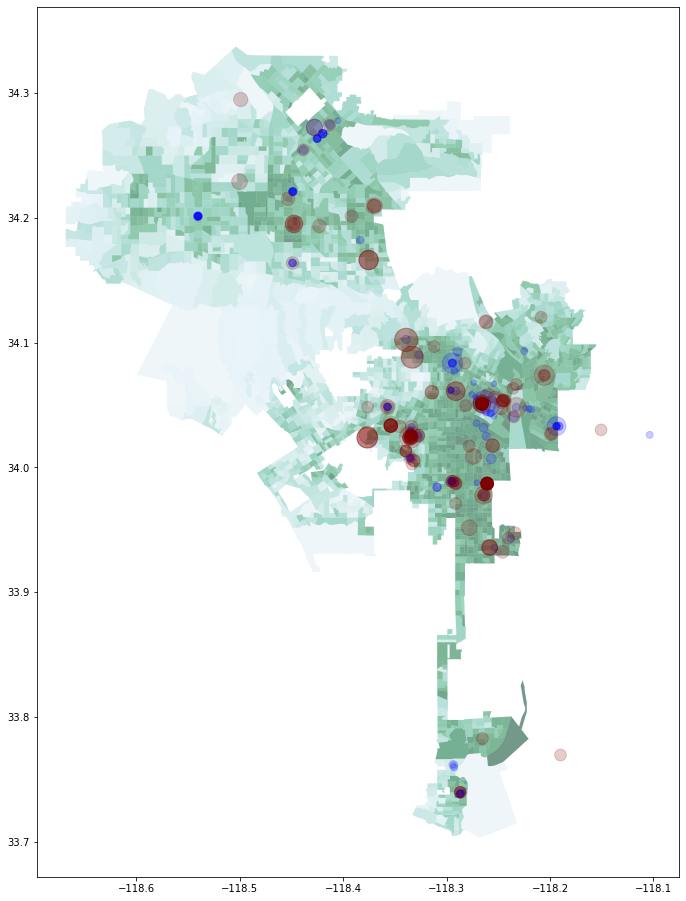

In [17]:
ax = city.plot(alpha=0.1, figsize=(16,16))
lmi_pct_city.plot(ax=ax, cmap="BuGn", column="Lowmod_pct", alpha=0.5)

high_performing.plot(markersize=numpy.sqrt(high_performing.Funding)/10., ax=ax, color="blue", alpha=0.2)
low_performing.plot(markersize=numpy.sqrt(low_performing.Funding)/10., ax=ax, color="maroon", alpha=0.2)